In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score

## Loading the dataset

In [2]:
data = pd.read_csv("D:\\Data\\german_credit_data.csv")
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


Age (numeric)<br>
Sex (text: male, female)<br>
Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
Housing (text: own, rent, or free)<br>
Saving accounts (text - little, moderate, quite rich, rich)<br>
Checking account (numeric, in DM - Deutsch Mark)<br>
Credit amount (numeric, in DM)<br>
Duration (numeric, in month)<br>
Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
Risk (Value target - Good or Bad Risk)<br>

In [3]:
data.drop(data[data['Purpose'] == 'business'].index, inplace=True)

## EDA

In [4]:
data.shape

(903, 11)

Dataset consists of 1000 observations and 11 columns

In [5]:
data.duplicated().sum()

0

No duplicated rows

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        903 non-null    int64 
 1   Age               903 non-null    int64 
 2   Sex               903 non-null    object
 3   Job               903 non-null    int64 
 4   Housing           903 non-null    object
 5   Saving accounts   734 non-null    object
 6   Checking account  546 non-null    object
 7   Credit amount     903 non-null    int64 
 8   Duration          903 non-null    int64 
 9   Purpose           903 non-null    object
 10  Risk              903 non-null    object
dtypes: int64(5), object(6)
memory usage: 84.7+ KB


### Functions

In [7]:
# Class for analysis
class StatisticAnalysis:
    def __init__(self, data): # truyền vào data là cả cái dataset luôn
        self.data = data
        
    
    def check_null(self, width=12, height=5):
        print(self.data.isnull().sum())

        null_df = self.data.isnull().sum()/self.data.shape[0] * 100
        null_df = null_df[null_df != 0].sort_values(ascending=False).reset_index()
        null_df.columns = ['feature', 'null_percentage']
        plt.figure(figsize=(width,height))
        sns.barplot(x = null_df['null_percentage'], y= null_df['feature'],
                    palette='coolwarm');
        plt.title('Null percentage per column', fontsize=20)
        plt.show()
        

    def correlation(self, width = 12, height = 10, drop_cols = None):
        num_df = self.data._get_numeric_data()
        if drop_cols != None:
            num_df.drop(columns=drop_cols, inplace=True)
        corr_matrix = num_df.corr()
        plt.figure(figsize=(width, height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, 
                    fmt=".2f", linewidths=0.5,
                    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
        )
        plt.title('Correlation Heatmap')
        plt.show()

In [8]:
class UnivariateAnalysis:
    def __init__(self, data): # truyền vào cả dataframe
        self.data = data
        # self.cnt = self.data.value_counts()
    
    def visualize(self, x = str, width=20, height=8, rotate = None):
        '''
            use for categorical variables only
            + x là tên cột muốn visualize, x là cột có datatype dạng object
        '''
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height))
        # color = sns.color_palette('Set3', len(self.cnt))
        self.cnt = self.data[x].value_counts()
        ax1.pie(self.cnt, autopct='%.2f%%', labels=self.cnt.index)

        ax2.bar(self.cnt.index, self.cnt.values)
        if rotate != None:
            for tick in ax2.get_xticklabels():
                tick.set_rotation(rotate)
        if self.data[x].nunique() == 2:
            if 0 in self.data[x].unique() and 1 in self.data[x].unique():
                ax2.set_xticks([0,1])
                ax2.set_xticklabels(self.cnt.index)
        plt.suptitle(f'Distribution of {x}')
        plt.show()

    def visualize_numeric(self, x = str, width=20, height=10, kde=False, common_bins=False):
        print(self.data[x].describe())
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height))
        sns.histplot(data=self.data, x=x, ax=ax1, kde=kde, common_bins=common_bins)
        sns.boxplot(data=self.data, x=x, ax=ax2)
        fig.suptitle(f'Distribution of {x}')
        plt.show()

In [9]:
stat_analysis = StatisticAnalysis(data)

### Number of null values each column

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     169
Checking account    357
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


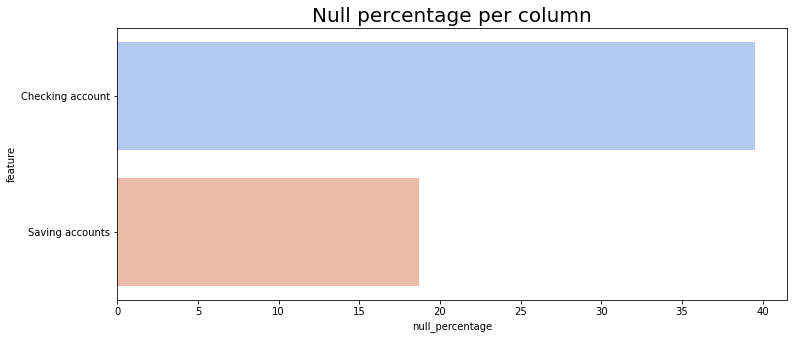

In [10]:
stat_analysis.check_null()

There are null values in checking account and Saving account columns, account for about 39% and 18% respectively

### Check for multicollinearity

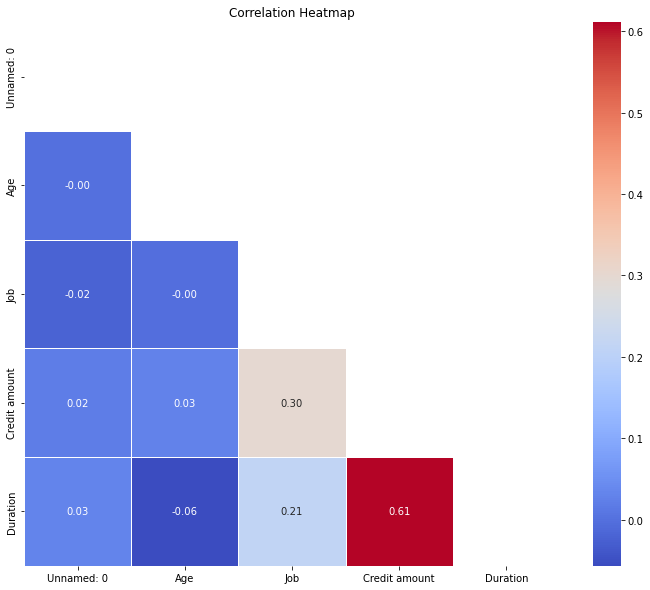

In [11]:
stat_analysis.correlation()

There are no multicollinearity in the dataset. It seems to be the higher the credit amount, the higher the duration

### Target "Risk"

In [12]:
univar_analysis = UnivariateAnalysis(data)

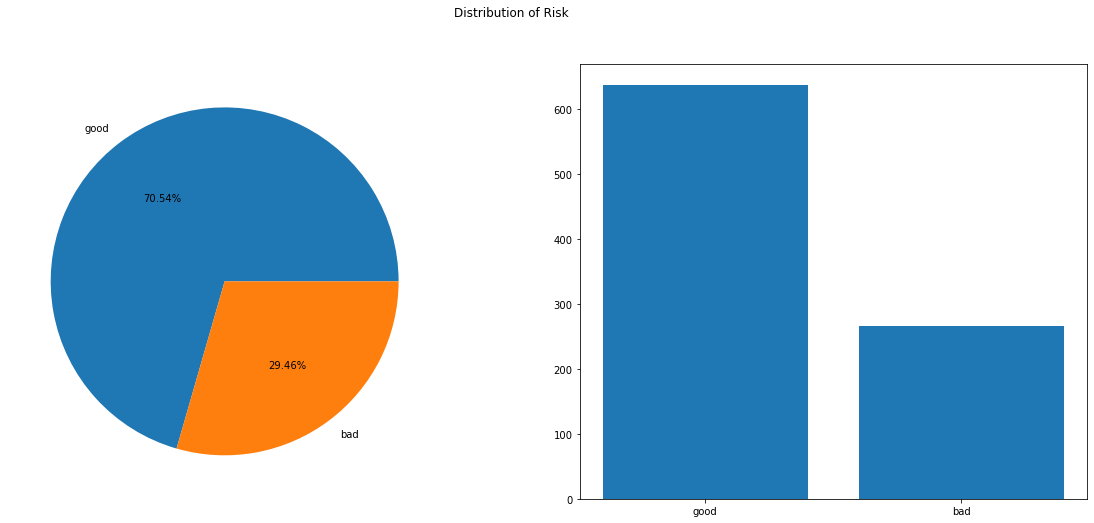

In [13]:
univar_analysis.visualize('Risk')

It can be seen an imbalance in the distribution of target Risk

### Age 

count    903.000000
mean      35.552602
std       11.378942
min       19.000000
25%       27.000000
50%       33.000000
75%       42.000000
max       75.000000
Name: Age, dtype: float64


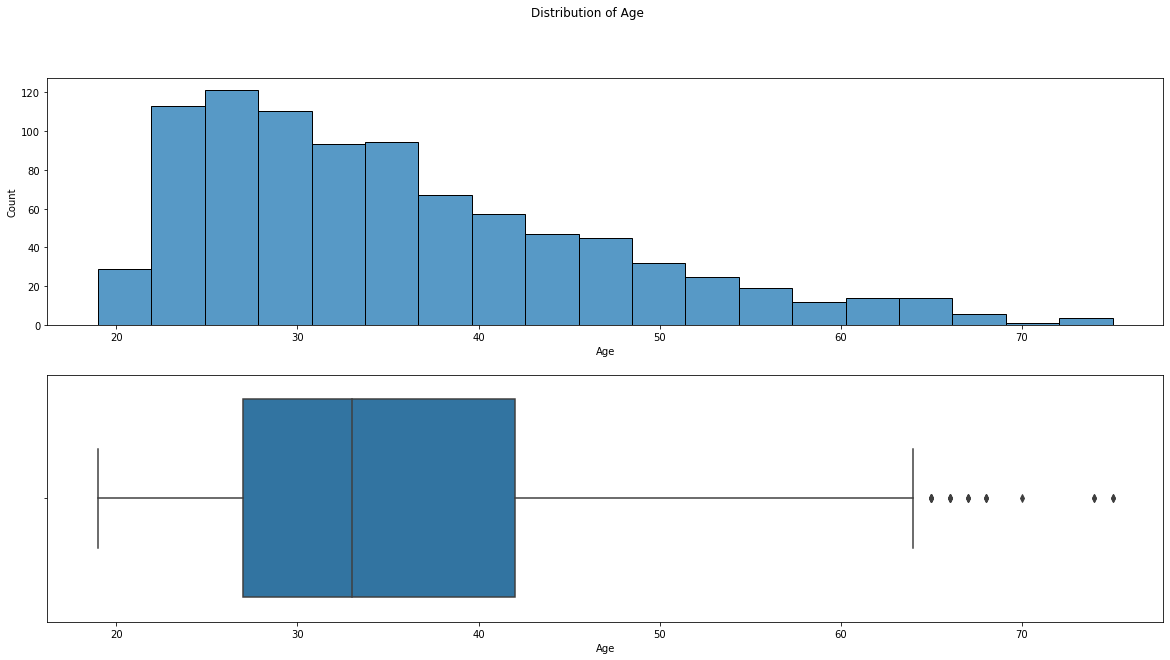

In [14]:
univar_analysis.visualize_numeric('Age')

Most applicant are young people

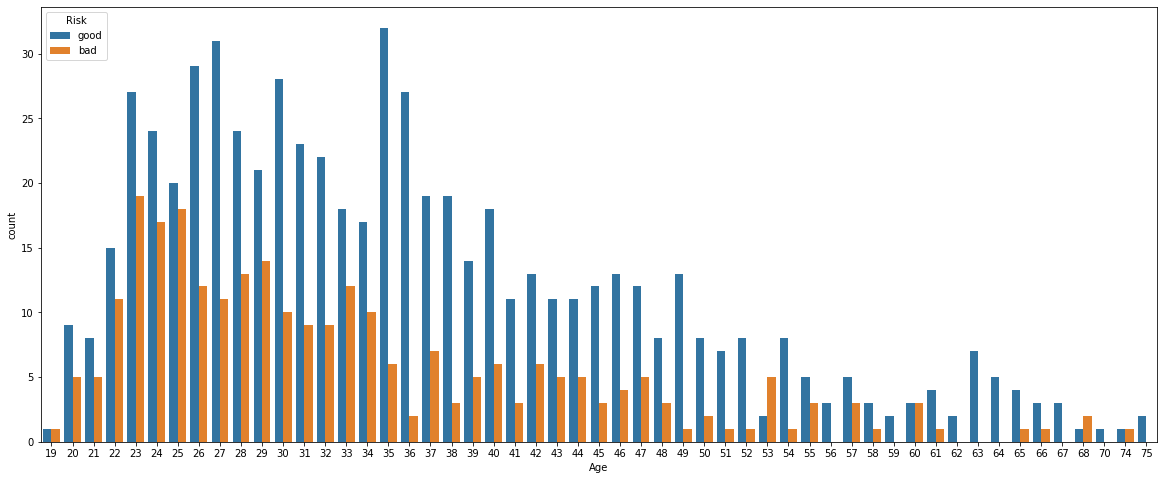

In [15]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Age", hue="Risk")
plt.show()

Some certain age (22-25, 28-29, 53, 60-61) has very high percentage of bad credit

### Sex

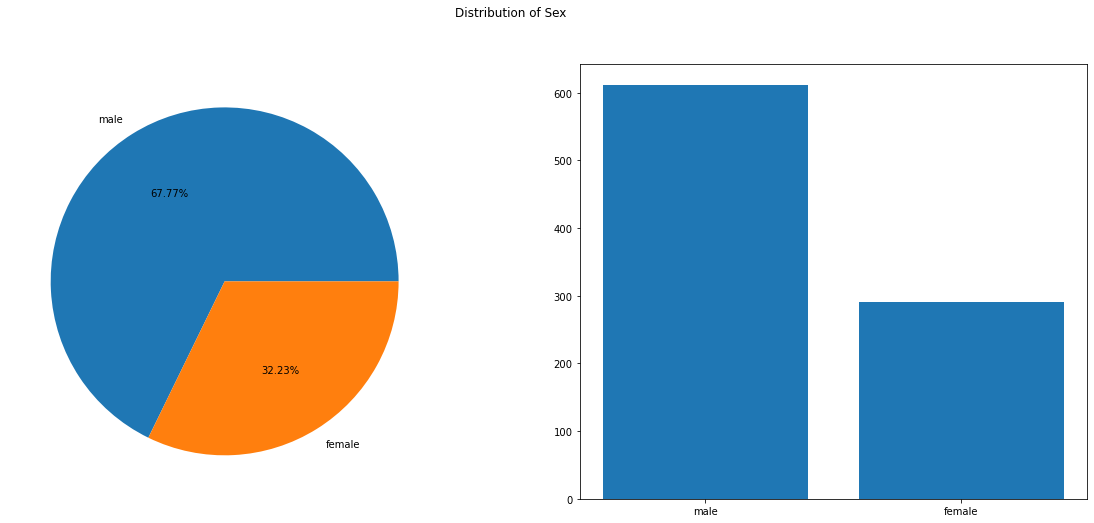

In [16]:
univar_analysis.visualize('Sex')

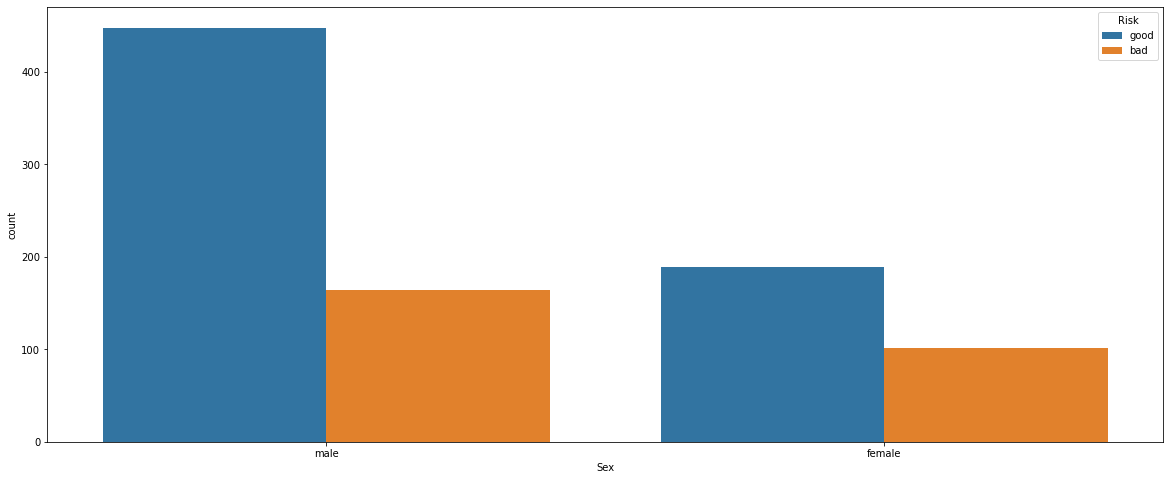

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Sex", hue="Risk")
plt.show()

Female has more percentage of bad credit than male

### Purpose

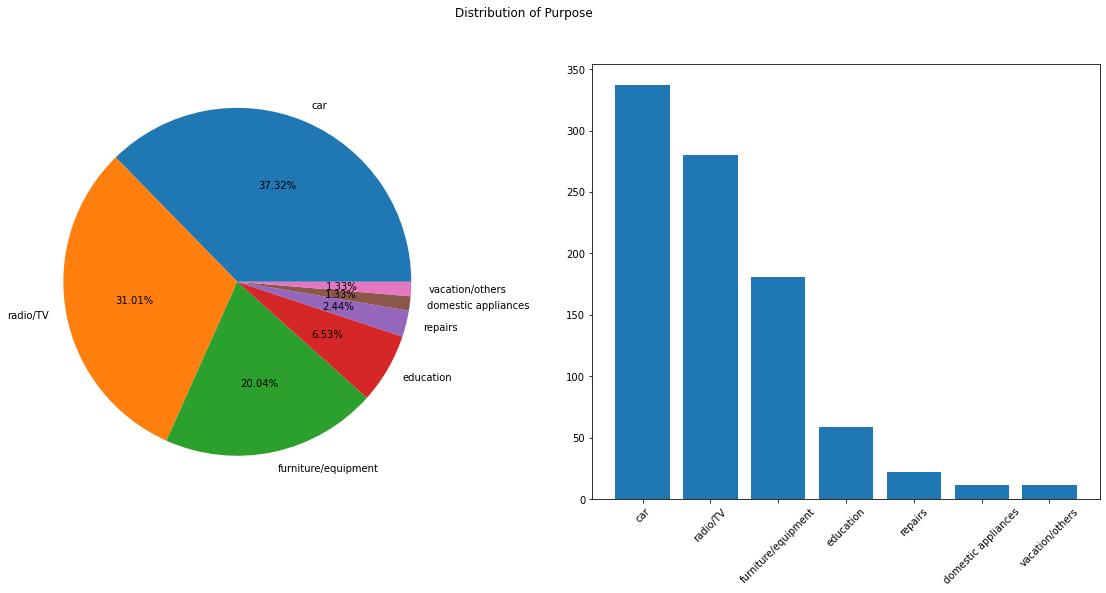

In [18]:
univar_analysis.visualize('Purpose', rotate = 45)

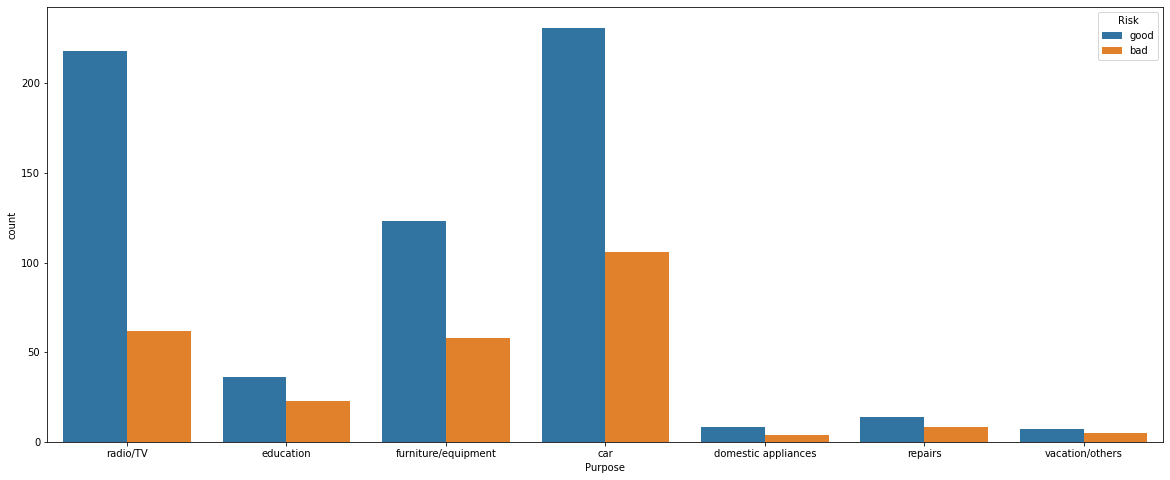

In [19]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Purpose", hue="Risk")
plt.show()

### Credit amount

count      903.000000
mean      3176.000000
std       2760.371135
min        250.000000
25%       1340.500000
50%       2247.000000
75%       3842.500000
max      18424.000000
Name: Credit amount, dtype: float64


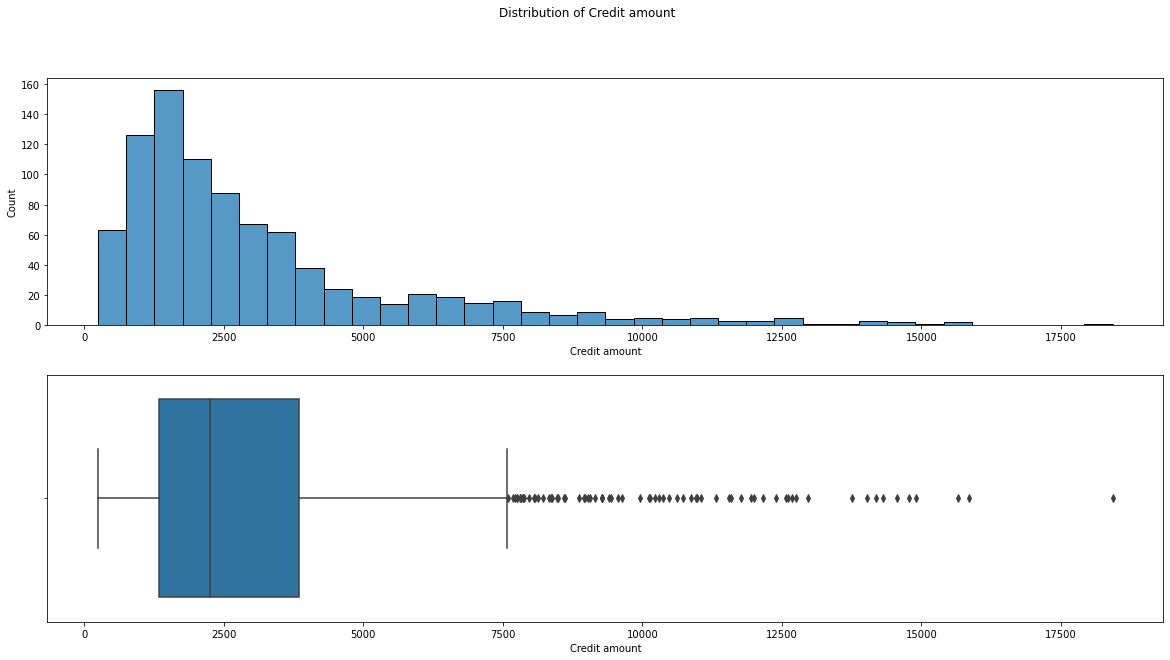

In [20]:
univar_analysis.visualize_numeric('Credit amount')

Most credit amount < 5000 Marks. Some credit amount extremely large (> 15000 Marks) 

### Credit duration

count    903.000000
mean      20.254707
std       11.741743
min        4.000000
25%       12.000000
50%       18.000000
75%       24.000000
max       72.000000
Name: Duration, dtype: float64


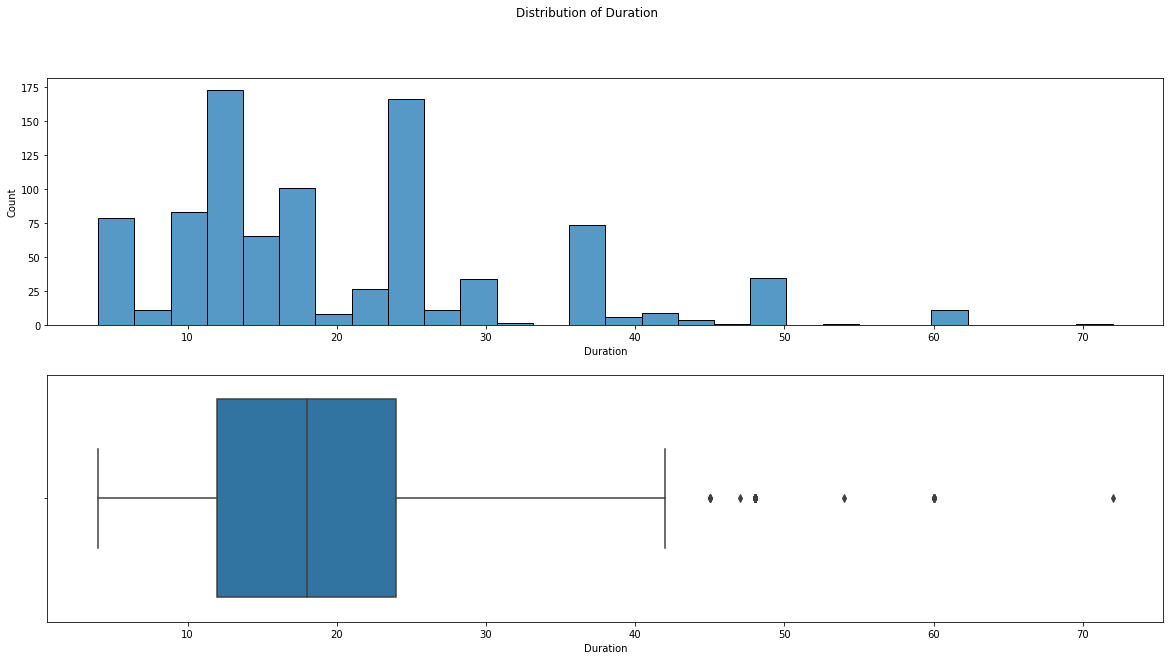

In [21]:
univar_analysis.visualize_numeric('Duration')

Some credit has duration extremely long (> 40 years)

### Saving account

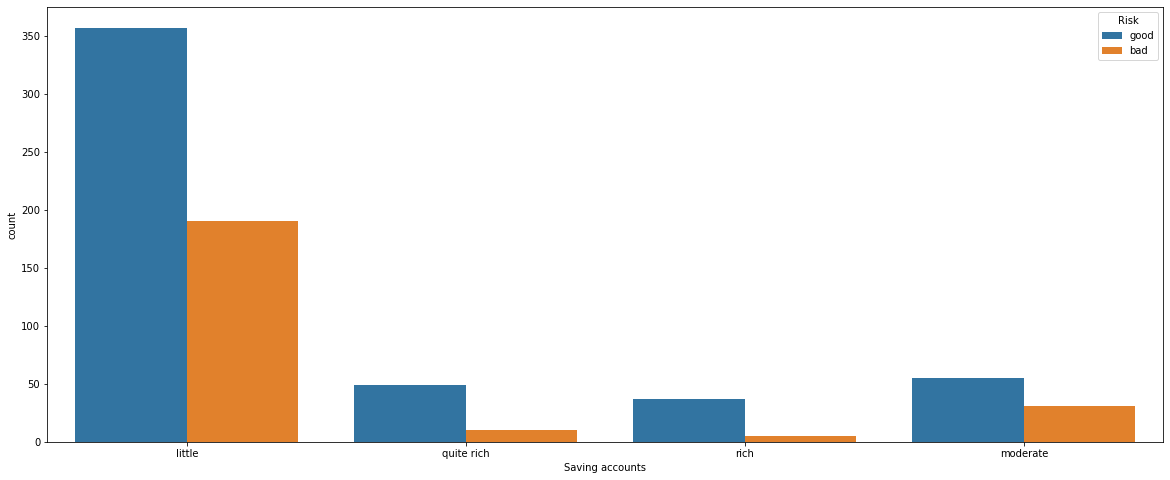

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Saving accounts", hue="Risk")
plt.show()

People who has quite rich and rich saving account is very likely to have good credit

### Checking account

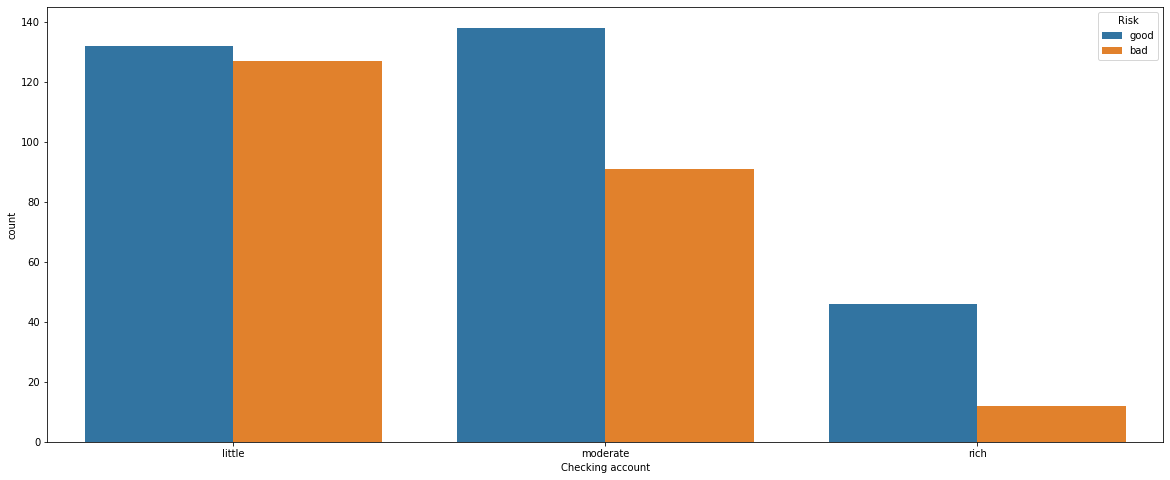

In [23]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Checking account", hue="Risk")
plt.show()

The same trend can be seen with checking accounts

### Housing

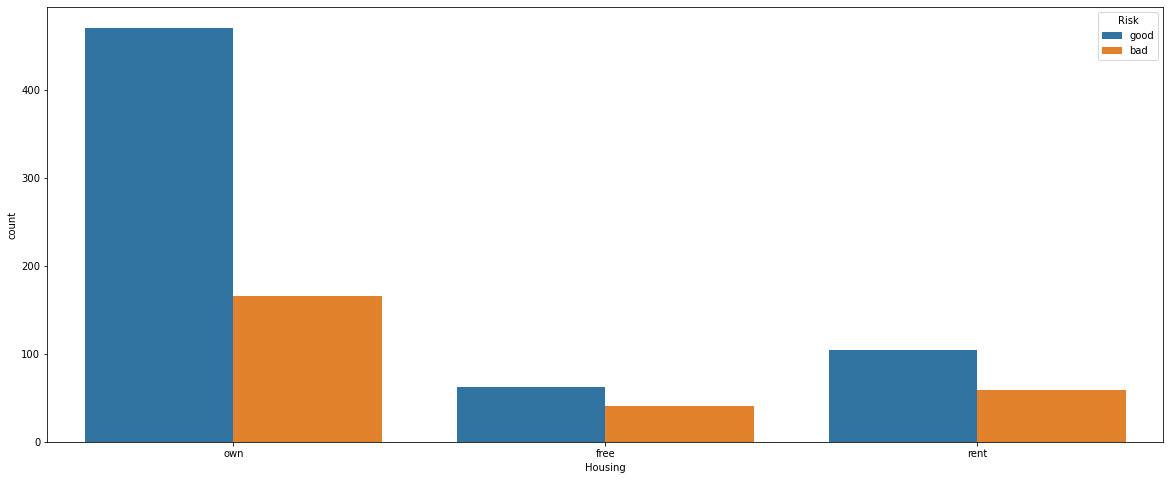

In [24]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Housing", hue="Risk")
plt.show()

People who is house-owner is more likely to pay their debt

### Job

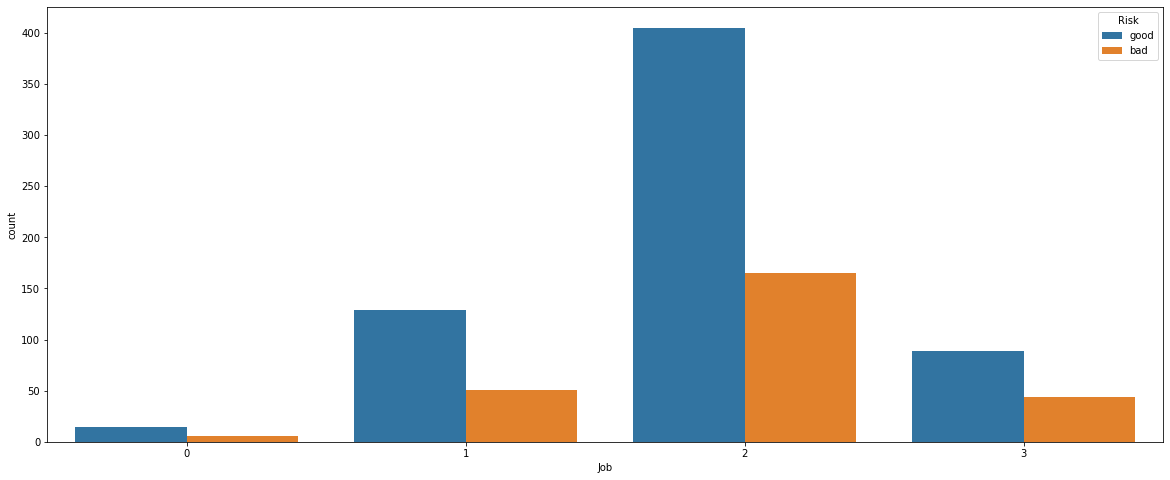

In [25]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.countplot(data=data, x="Job", hue="Risk")
plt.show()

Most loan applicants are skilled and highly-skilled laborers.

## Preprocessing and Feature Engineering

In [26]:
original_data = data.copy()
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        903 non-null    int64 
 1   Age               903 non-null    int64 
 2   Sex               903 non-null    object
 3   Job               903 non-null    int64 
 4   Housing           903 non-null    object
 5   Saving accounts   734 non-null    object
 6   Checking account  546 non-null    object
 7   Credit amount     903 non-null    int64 
 8   Duration          903 non-null    int64 
 9   Purpose           903 non-null    object
 10  Risk              903 non-null    object
dtypes: int64(5), object(6)
memory usage: 116.9+ KB


In [27]:
#Fill nan
data['Saving accounts'] = data['Saving accounts'].fillna('no')
data['Checking account'] = data['Checking account'].fillna('no')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        903 non-null    int64 
 1   Age               903 non-null    int64 
 2   Sex               903 non-null    object
 3   Job               903 non-null    int64 
 4   Housing           903 non-null    object
 5   Saving accounts   903 non-null    object
 6   Checking account  903 non-null    object
 7   Credit amount     903 non-null    int64 
 8   Duration          903 non-null    int64 
 9   Purpose           903 non-null    object
 10  Risk              903 non-null    object
dtypes: int64(5), object(6)
memory usage: 116.9+ KB


In [28]:
#Drop outliers
data = data[data['Credit amount'] <= 15000]

In [29]:
# Encoding target variable 
data['Risk'] = data['Risk'].replace({
    'good': 0, # Good = 0
    'bad': 1  # Bad = 1
})

C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2671387777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Risk'] = data['Risk'].replace({


In [30]:
# One-hot encoding
data = pd.get_dummies(data, columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'])

In [31]:
# Drop Unnamed:0
data.drop(columns=['Unnamed: 0'], inplace=True)

In [32]:
data.head()

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_moderate,Checking account_no,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,1,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,49,1,2096,12,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,45,2,7882,42,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0


### Train test split

In [33]:
#Creating X,y
X = data.drop('Risk', 1).values
y = data['Risk'].values

# Spliting train and test in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(df, test_size = 0.20, random_state=42)

C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2432596796.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop('Risk', 1).values


In [34]:
print('Train Data:')
print(X_train.shape)
print('Test Data:')
print(X_test.shape)

Train Data:
(720, 25)
Test Data:
(180, 25)


## Logistic Regression and other models

In [35]:
# Initialize logistic regression model with 'sag' solver
lr_model = LogisticRegression(max_iter=1000,random_state=0)

# Train the model
lr_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')

# Predictions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average = 'macro')
gini_score = 2 * roc_auc_score(y_test, y_pred_proba) - 1

print(f"Accuracy: {accuracy * 100.0}%")
print(f"Recall: {recall}")
print(f"Gini Coefficient: {gini_score}")
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation Gini Coefficient: {np.mean(2*cv_scores-1)}")

Accuracy: 76.66666666666667%
Recall: 0.6645271715875054
Gini Coefficient: 0.6593923833975182
Cross-Validation ROC-AUC Scores: [0.67810458 0.7735761  0.74603175 0.75491357 0.73241771]
Average Cross-Validation Gini Coefficient: 0.474017479752182


In [36]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto', probability=True)))
models.append(('XGB', XGBClassifier()))

for name, model in models:
    model = model
    # Train the model
    model.fit(X_train, y_train)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    #Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average = 'macro')
    gini_score = 2 * roc_auc_score(y_test, y_pred_proba) - 1
    
    print("-" * 10)
    print(name)
    print(f"Accuracy: {accuracy * 100.0}%")
    print(f"Recall: {recall}")
    print(f"Gini Coefficient: {gini_score}")
    print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
    print(f"Average Cross-Validation Gini Coefficient: {np.mean(2*cv_scores-1)}")

C:\Users\Latitude E7490\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Latitude E7490\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

----------
LR
Accuracy: 76.11111111111111%
Recall: 0.6463414634146342
Gini Coefficient: 0.6485522749964341
Cross-Validation ROC-AUC Scores: [0.68323996 0.7735761  0.74603175 0.75491357 0.72933933]
Average Cross-Validation Gini Coefficient: 0.474840282628167
----------
LDA
Accuracy: 77.77777777777779%
Recall: 0.686777920410783
Gini Coefficient: 0.6605334474397375
Cross-Validation ROC-AUC Scores: [0.67857143 0.79388422 0.73996265 0.72957613 0.70944826]
Average Cross-Validation Gini Coefficient: 0.4605770763589989
----------
KNN
Accuracy: 65.0%
Recall: 0.5415062045357295
Gini Coefficient: 0.0711738696334332
Cross-Validation ROC-AUC Scores: [0.53606443 0.55450514 0.59360411 0.49502723 0.55375326]
Average Cross-Validation Gini Coefficient: 0.09318166290906604
----------
DT
Accuracy: 68.33333333333333%
Recall: 0.6270860077021823
Gini Coefficient: 0.2541720154043645
Cross-Validation ROC-AUC Scores: [0.59243697 0.60854342 0.65266106 0.59093062 0.64207909]
Average Cross-Validation Gini Coeffici

## Logistic Regression with Weight of Evidence and Information Value

### Calculate WoE and IV

In [37]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        }) 
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='WoE')
    return dset, iv

In [38]:
data = original_data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        903 non-null    int64 
 1   Age               903 non-null    int64 
 2   Sex               903 non-null    object
 3   Job               903 non-null    int64 
 4   Housing           903 non-null    object
 5   Saving accounts   734 non-null    object
 6   Checking account  546 non-null    object
 7   Credit amount     903 non-null    int64 
 8   Duration          903 non-null    int64 
 9   Purpose           903 non-null    object
 10  Risk              903 non-null    object
dtypes: int64(5), object(6)
memory usage: 116.9+ KB


In [39]:
#Fill nan
data['Saving accounts'] = data['Saving accounts'].fillna('no')
data['Checking account'] = data['Checking account'].fillna('no')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        903 non-null    int64 
 1   Age               903 non-null    int64 
 2   Sex               903 non-null    object
 3   Job               903 non-null    int64 
 4   Housing           903 non-null    object
 5   Saving accounts   903 non-null    object
 6   Checking account  903 non-null    object
 7   Credit amount     903 non-null    int64 
 8   Duration          903 non-null    int64 
 9   Purpose           903 non-null    object
 10  Risk              903 non-null    object
dtypes: int64(5), object(6)
memory usage: 116.9+ KB


In [40]:
#Drop outliers
data = data[data['Credit amount'] <= 15000]

In [41]:
# Convert categorical variables into category datatype
data['Sex'] = pd.Categorical(data['Sex'])
data['Housing'] = pd.Categorical(data['Housing'])
data['Saving accounts'] = pd.Categorical(data['Saving accounts'])
data['Checking account'] = pd.Categorical(data['Checking account'])
data['Purpose'] = pd.Categorical(data['Purpose'])
data['Job'] = pd.Categorical(data['Job'])

# Drop Unnamed:0
data.drop(columns=['Unnamed: 0'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               900 non-null    int64   
 1   Sex               900 non-null    category
 2   Job               900 non-null    category
 3   Housing           900 non-null    category
 4   Saving accounts   900 non-null    category
 5   Checking account  900 non-null    category
 6   Credit amount     900 non-null    int64   
 7   Duration          900 non-null    int64   
 8   Purpose           900 non-null    category
 9   Risk              900 non-null    object  
dtypes: category(6), int64(3), object(1)
memory usage: 41.6+ KB


C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2997029768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sex'] = pd.Categorical(data['Sex'])
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2997029768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Housing'] = pd.Categorical(data['Housing'])
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2997029768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [42]:
# Encoding target variable 
data['Risk'] = data['Risk'].replace({
    'good': 0, # Good = 0
    'bad': 1  # Bad = 1
})

C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2671387777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Risk'] = data['Risk'].replace({


In [43]:
def split_train_test(df, test_size, seed):
    
    '''
    This function splits a dataframe for training and testing according to test_size
    '''
    
    train, test = train_test_split(df, test_size = test_size, shuffle = True, random_state = seed) # Splitting data

    print(f'\n Train shape: {train.shape}\n')
    print(f'\n {len(train):,.0f} Samples \n')
    print(f'\n {len(train.columns)} Attributes \n')
    display(train.head(10))
    print('\n' * 2)

    print(f'\n Test shape: {test.shape:}\n')
    print(f'\n {len(test):,.0f} Samples \n')
    print(f'\n {len(test.columns)} Attributes \n')
    display(test.head(10))
    
    return train, test

In [44]:
train, test = split_train_test(data, 0.2, 123)


 Train shape: (720, 10)


 720 Samples 


 10 Attributes 



,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
385,25,female,2,own,little,no,2238,18,radio/TV,0
753,25,female,2,own,little,no,5771,30,radio/TV,0
261,55,female,2,own,little,little,1603,24,radio/TV,0
240,29,female,2,own,no,little,915,24,car,1
215,39,female,1,own,no,moderate,932,6,education,0
539,45,female,1,own,little,rich,3049,18,furniture/equipment,0
206,43,male,2,own,little,no,1935,12,furniture/equipment,0
664,50,female,1,own,little,rich,1047,6,education,0
420,20,female,2,rent,rich,no,3186,15,car,0
393,31,female,2,own,little,little,1957,6,radio/TV,0






 Test shape: (180, 10)


 180 Samples 


 10 Attributes 



,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
681,37,male,2,free,no,no,2279,12,radio/TV,0
578,27,male,2,own,little,moderate,2820,36,car,1
766,31,male,1,own,little,little,3108,30,furniture/equipment,1
508,28,male,2,own,little,no,1413,24,radio/TV,0
98,36,male,2,own,little,moderate,2337,36,radio/TV,0
497,40,male,2,own,little,no,1585,24,furniture/equipment,0
329,28,male,2,own,little,moderate,1068,6,radio/TV,0
926,21,female,2,rent,little,little,1049,18,furniture/equipment,0
953,26,female,3,own,little,no,10974,36,furniture/equipment,1
53,31,male,2,own,no,no,3378,18,car,0


In [45]:
# Convert numeric variables into bins
train['Age_bin']= pd.qcut(train['Age'], 10)
train['Credit_AMT_bin']= pd.qcut(train['Credit amount'], 10)
train['Duration_bin']= pd.qcut(train['Duration'], 6)

In [46]:
train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_bin,Credit_AMT_bin,Duration_bin
385,25,female,2,own,little,no,2238,18,radio/TV,0,"(23.0, 26.0]","(2217.5, 2734.0]","(12.0, 18.0]"
753,25,female,2,own,little,no,5771,30,radio/TV,0,"(23.0, 26.0]","(4577.4, 6893.1]","(24.0, 30.0]"
261,55,female,2,own,little,little,1603,24,radio/TV,0,"(52.1, 75.0]","(1449.7, 1832.6]","(18.0, 24.0]"
240,29,female,2,own,no,little,915,24,car,1,"(28.0, 30.0]","(901.8, 1252.8]","(18.0, 24.0]"
215,39,female,1,own,no,moderate,932,6,education,0,"(36.0, 39.3]","(901.8, 1252.8]","(3.999, 10.0]"


In [47]:
# Subset data for WoE and IV calculation
data2 = train[['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',\
              'Purpose', 'Age_bin', 'Credit_AMT_bin', 'Duration_bin', 'Risk']]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 385 to 562
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Sex               720 non-null    category
 1   Job               720 non-null    category
 2   Housing           720 non-null    category
 3   Saving accounts   720 non-null    category
 4   Checking account  720 non-null    category
 5   Purpose           720 non-null    category
 6   Age_bin           720 non-null    category
 7   Credit_AMT_bin    720 non-null    category
 8   Duration_bin      720 non-null    category
 9   Risk              720 non-null    int64   
dtypes: category(9), int64(1)
memory usage: 19.9 KB


In [48]:
# computing WoE and IV
woe_list = [] #Store WoE for each bins
iv_df = pd.DataFrame(columns=['Variable','IV']) #Store IV for each feature

for col in data2.columns:
    if col == 'Risk':
        continue
    else:
        df, iv = calculate_woe_iv(data2, col, 'Risk')
    woe_list.append(df)
    iv_df = iv_df.append({"Variable" :col, "IV" : iv,},ignore_index=True)   

C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\959460829.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iv_df = iv_df.append({"Variable" :col, "IV" : iv,},ignore_index=True)
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\959460829.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iv_df = iv_df.append({"Variable" :col, "IV" : iv,},ignore_index=True)
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\959460829.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iv_df = iv_df.append({"Variable" :col, "IV" : iv,},ignore_index=True)
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\959460829.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

### Feature selection

In [49]:
# Defining threshold values for IVs
def interpret_iv(iv):
    if iv < 0.02:
        return 'Useless for prediction'
    elif iv < 0.1:
        return 'Weak predictor'
    elif iv < 0.3:
        return 'Medium predictor'
    elif iv < 0.5:
        return 'Strong predictor'
    else:
        return 'Suspicious or too good predictor'

In [50]:
iv_df

,Variable,IV
0,Sex,0.022333
1,Job,0.002522
2,Housing,0.059597
3,Saving accounts,0.123136
4,Checking account,0.683344
5,Purpose,0.06387
6,Age_bin,0.159072
7,Credit_AMT_bin,0.134809
8,Duration_bin,0.197315


In [51]:
for index, row in iv_df.iterrows():
    feature = row['Variable']
    iv = row['IV']
    status = interpret_iv(iv)
    print(f"{feature}: {status}")

Sex: Weak predictor
Job: Useless for prediction
Housing: Weak predictor
Saving accounts: Medium predictor
Checking account: Suspicious or too good predictor
Purpose: Weak predictor
Age_bin: Medium predictor
Credit_AMT_bin: Medium predictor
Duration_bin: Medium predictor


In [52]:
# Feature selection
data3 = train[['Saving accounts', 'Checking account', 'Age_bin', 'Credit_AMT_bin', 'Duration_bin', 'Risk']]
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 385 to 562
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Saving accounts   720 non-null    category
 1   Checking account  720 non-null    category
 2   Age_bin           720 non-null    category
 3   Credit_AMT_bin    720 non-null    category
 4   Duration_bin      720 non-null    category
 5   Risk              720 non-null    int64   
dtypes: category(5), int64(1)
memory usage: 16.3 KB


### Replace bins and categorical variables by WoE values

In [53]:
# for df, (index, row) in zip(woe_list, iv_df.iterrows()):
#     print(df, (index, row))

In [54]:
saving_acc_dict = dict(zip(woe_list[3]['Value'],woe_list[3]['WoE']))
checking_acc_dict = dict(zip(woe_list[4]['Value'],woe_list[4]['WoE']))
age_bin_dict = dict(zip(woe_list[6]['Value'],woe_list[6]['WoE']))
credit_amt_bin_dict = dict(zip(woe_list[7]['Value'],woe_list[7]['WoE']))
duration_bin_dict = dict(zip(woe_list[8]['Value'],woe_list[8]['WoE']))
# age_bin_dict = woe_list[6][['Value', 'WoE']].set_index('Value').to_dict()
# age_bin_dict

In [55]:
# data3['Age_bin'] = data3['Age_bin'].astype(str) #Convert datatype to 'string'
# data3['Age_bin'] = data3['Age_bin'].replace(age_bin_dict, inplace = True)
data3.replace({'Saving accounts': saving_acc_dict}, inplace=True)
data3.replace({'Checking account': checking_acc_dict}, inplace=True)
data3.replace({'Credit_AMT_bin': credit_amt_bin_dict}, inplace=True)
data3.replace({'Duration_bin': duration_bin_dict}, inplace=True)
data3.replace({'Age_bin': age_bin_dict}, inplace=True)
data3

C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\3719643556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.replace({'Saving accounts': saving_acc_dict}, inplace=True)
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\3719643556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.replace({'Checking account': checking_acc_dict}, inplace=True)
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\3719643556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Saving accounts,Checking account,Age_bin,Credit_AMT_bin,Duration_bin,Risk
385,-0.180042,1.220675,-0.467606,-0.086576,-0.099341,0
753,-0.180042,1.220675,-0.467606,-0.396731,-0.173588,0
261,-0.180042,-0.750371,0.266563,0.427444,0.061844,0
240,0.431335,-0.750371,-0.239728,0.047954,0.061844,1
215,0.431335,-0.488486,0.478737,0.047954,0.832909,0
...,...,...,...,...,...,...
113,-0.180042,1.220675,-0.467606,-0.627972,-0.721840,1
359,-0.180042,-0.750371,-0.557355,-0.086576,-0.173588,1
427,1.171884,1.220675,0.385211,0.047954,-0.099341,0
409,0.539362,0.478737,0.065892,0.047954,0.051700,1


In [56]:
# train['Age_bin']= pd.qcut(train['Age'], 10)
# train['Credit_AMT_bin']= pd.qcut(train['Credit amount'], 10)
# train['Duration_bin']= pd.qcut(train['Duration'], 6)
bin_edges_age = train['Age_bin'].cat.categories
bin_edges_credit_amt = train['Credit_AMT_bin'].cat.categories
bin_edges_duration = train['Duration_bin'].cat.categories

print(bin_edges_credit_amt)

IntervalIndex([(249.999, 901.8], (901.8, 1252.8], (1252.8, 1449.7], (1449.7, 1832.6], (1832.6, 2217.5], (2217.5, 2734.0], (2734.0, 3433.3], (3433.3, 4577.4], (4577.4, 6893.1], (6893.1, 14896.0]], dtype='interval[float64, right]')


In [57]:
test['Age_bin'] = pd.cut(test['Age'], bins=bin_edges_age)
test['Credit_AMT_bin'] = pd.cut(test['Credit amount'], bins=bin_edges_credit_amt)
test['Duration_bin'] = pd.cut(test['Duration'], bins=bin_edges_duration)

test.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_bin,Credit_AMT_bin,Duration_bin
681,37,male,2,free,no,no,2279,12,radio/TV,0,"(36.0, 39.3]","(2217.5, 2734.0]","(10.0, 12.0]"
578,27,male,2,own,little,moderate,2820,36,car,1,"(26.0, 28.0]","(2734.0, 3433.3]","(30.0, 72.0]"
766,31,male,1,own,little,little,3108,30,furniture/equipment,1,"(30.0, 33.0]","(2734.0, 3433.3]","(24.0, 30.0]"
508,28,male,2,own,little,no,1413,24,radio/TV,0,"(26.0, 28.0]","(1252.8, 1449.7]","(18.0, 24.0]"
98,36,male,2,own,little,moderate,2337,36,radio/TV,0,"(33.0, 36.0]","(2217.5, 2734.0]","(30.0, 72.0]"


In [58]:
test.replace({'Saving accounts': saving_acc_dict}, inplace=True)
test.replace({'Checking account': checking_acc_dict}, inplace=True)
test.replace({'Credit_AMT_bin': credit_amt_bin_dict}, inplace=True)
test.replace({'Duration_bin': duration_bin_dict}, inplace=True)
test.replace({'Age_bin': age_bin_dict}, inplace=True)
test.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_bin,Credit_AMT_bin,Duration_bin
681,37,male,2,free,0.431335,1.220675,2279,12,radio/TV,0,0.478737,-0.086576,0.051700
578,27,male,2,own,-0.180042,-0.488486,2820,36,car,1,0.065892,0.513829,-0.721840
766,31,male,1,own,-0.180042,-0.750371,3108,30,furniture/equipment,1,-0.193791,0.513829,-0.173588
508,28,male,2,own,-0.180042,1.220675,1413,24,radio/TV,0,0.065892,-0.086576,0.061844
98,36,male,2,own,-0.180042,-0.488486,2337,36,radio/TV,0,0.701881,-0.086576,-0.721840


In [59]:
test = test[['Saving accounts', 'Checking account', 'Age_bin', 'Credit_AMT_bin', 'Duration_bin', 'Risk']]

### Logistic Regression with WoE

In [60]:
#Creating X,y
X_train = data3.drop('Risk', 1).values
y_train = data3['Risk'].values
X_test = test.drop('Risk', 1).values
y_test = test['Risk'].values


C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2594282783.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = data3.drop('Risk', 1).values
C:\Users\Latitude E7490\AppData\Local\Temp\ipykernel_808\2594282783.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = test.drop('Risk', 1).values


In [61]:
print('Train Data:')
print(X_train.shape)
print('Test Data:')
print(X_test.shape)

Train Data:
(720, 5)
Test Data:
(180, 5)


In [62]:
# Initialize logistic regression model with 'sag' solver
lr_model = LogisticRegression(max_iter=1000,random_state=0)

# Train the model
lr_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')

# Predictions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average = 'macro')
gini_score = 2 * roc_auc_score(y_test, y_pred_proba) - 1

print(f"Accuracy: {accuracy * 100.0}%")
print(f"Recall: {recall}")
print(f"Gini Coefficient: {gini_score}")

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation Gini Coefficient: {np.mean(2*cv_scores-1)}")

Accuracy: 75.0%
Recall: 0.6346806105144149
Gini Coefficient: 0.6264838892029396
Cross-Validation ROC-AUC Scores: [0.73916647 0.73739048 0.77669903 0.77497666 0.79166667]
Average Cross-Validation Gini Coefficient: 0.5279597212631993


### Compare to other models

In [63]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto', probability=True)))
models.append(('XGB', XGBClassifier()))

for name, model in models:
    model = model
    # Train the model
    model.fit(X_train, y_train)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    #Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average = 'macro')
    gini_score = 2 * roc_auc_score(y_test, y_pred_proba) - 1
    
    print("-" * 10)
    print(name)
    print(f"Accuracy: {accuracy * 100.0}%")
    print(f"Recall: {recall}")
    print(f"Gini Coefficient: {gini_score}")
    print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
    print(f"Average Cross-Validation Gini Coefficient: {np.mean(2*cv_scores-1)}")

----------
LR
Accuracy: 75.0%
Recall: 0.6346806105144149
Gini Coefficient: 0.6264838892029396
Cross-Validation ROC-AUC Scores: [0.73916647 0.73739048 0.77669903 0.77497666 0.79166667]
Average Cross-Validation Gini Coefficient: 0.5279597212631993
----------
LDA
Accuracy: 76.66666666666667%
Recall: 0.6605426794799322
Gini Coefficient: 0.6129169022046355
Cross-Validation ROC-AUC Scores: [0.74082406 0.73336491 0.77717263 0.77497666 0.79516807]
Average Cross-Validation Gini Coefficient: 0.5286025263369221
----------
KNN
Accuracy: 73.88888888888889%
Recall: 0.6536178631995477
Gini Coefficient: 0.4520915771622387
Cross-Validation ROC-AUC Scores: [0.67913805 0.65901018 0.74780961 0.64869281 0.78256303]
Average Cross-Validation Gini Coefficient: 0.4068854742149445
----------
DT
Accuracy: 72.77777777777777%
Recall: 0.6680327868852459
Gini Coefficient: 0.3890616167326175
Cross-Validation ROC-AUC Scores: [0.53776936 0.54203173 0.58808904 0.56442577 0.59103641]
Average Cross-Validation Gini Coeffic